In [1]:
import os
from pathlib import Path
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2
import numpy as np
import tensorflow.compat.v2 as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.listdir("/content/drive/MyDrive/Project/Pneumonia-Detection-on-Chest-Xrays/chest_xray"))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [4]:
data_dir = Path("/content/drive/MyDrive/Project/Pneumonia-Detection-on-Chest-Xrays/chest_xray/chest_xray")

In [5]:
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [6]:
train_normal_dir = train_dir / 'NORMAL'
train_pneumonia_dir = train_dir / 'PNEUMONIA'

normal_cases = train_normal_dir.glob('*jpeg')
pneumonia_cases = train_pneumonia_dir.glob('*jpeg')

train_data = []
for img in normal_cases:
    train_data.append((img, 0))
for img in pneumonia_cases:
    train_data.append((img, 1))

train_df = pd.DataFrame(train_data, columns = ['Image Path', 'Label'], index = None)
train_df = train_df.sample(frac = 1.).reset_index(drop = True)
train_df.head(10)

,Image Path,Label
0,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
1,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
2,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
3,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
4,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
5,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
6,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
7,/content/drive/MyDrive/Project/Pneumonia-Detec...,0
8,/content/drive/MyDrive/Project/Pneumonia-Detec...,0
9,/content/drive/MyDrive/Project/Pneumonia-Detec...,1


1    3875
0    1341
Name: Label, dtype: int64


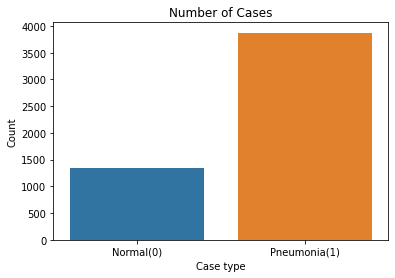

In [7]:
case_count = train_df['Label'].value_counts()
print(case_count)
plt.figure(figsize = (6, 4))
sns.barplot(x = case_count.index, y = case_count.values)
plt.title('Number of Cases')
plt.xlabel('Case type')
plt.ylabel('Count')
plt.xticks(range(len(case_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

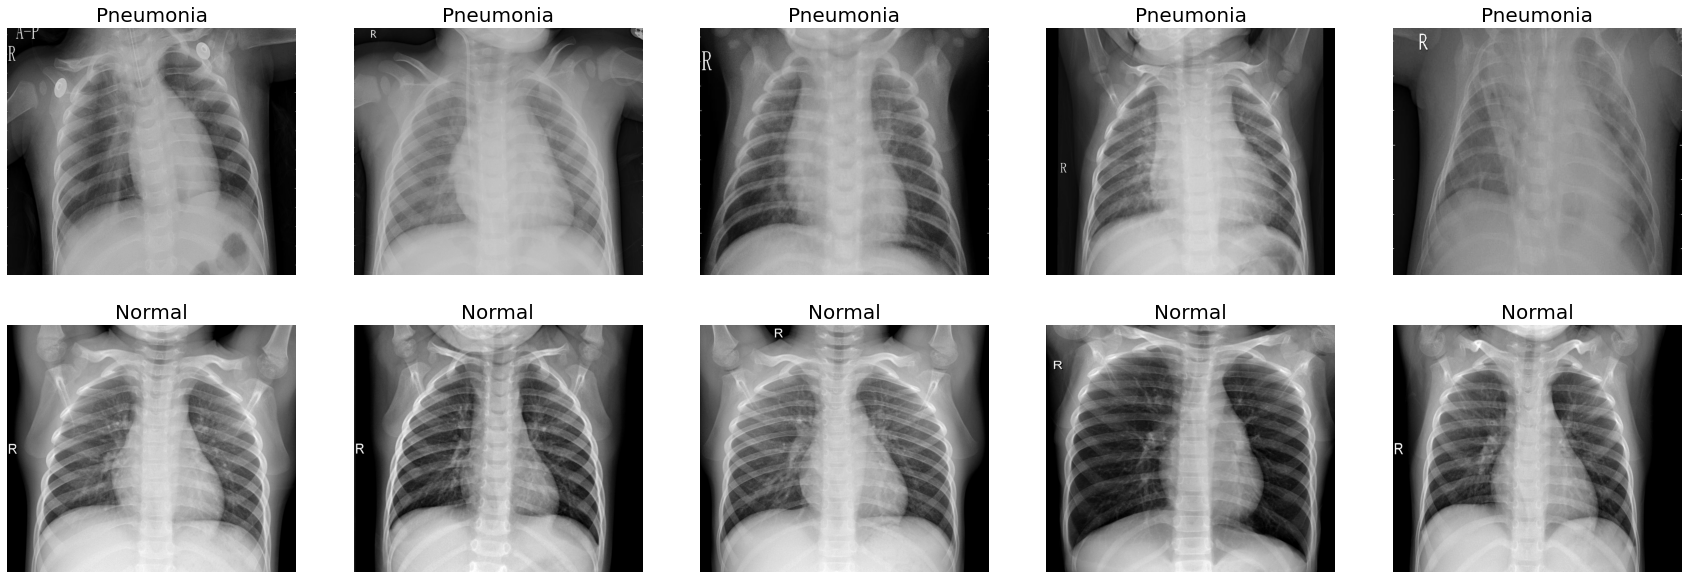

In [8]:
samples_pneumonia = (train_df[train_df['Label'] == 1]['Image Path'].iloc[:5]).tolist()
samples_normal = (train_df[train_df['Label'] == 0]['Image Path'].iloc[:5]).tolist()

total_samples = samples_pneumonia + samples_normal
del samples_pneumonia, samples_normal

f, ax = plt.subplots(2, 5, figsize=(30,10))
for i in range(0, 10):
    img = imread(total_samples[i])
    ax[i // 5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i // 5, i % 5].set_title("Pneumonia", size=20)
    else:
        ax[i // 5, i % 5].set_title("Normal", size=20)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')

plt.show()

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                  rotation_range=20 ,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  brightness_range=[0.6,0.9],
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator( rescale = 1.0/255)

In [10]:
# --------------------
# Flow training images in batches of 32 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(300, 300))     
# --------------------
# Flow validation images using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                         shuffle=False,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

# --------------------
# Flow validation images using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         shuffle=False,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

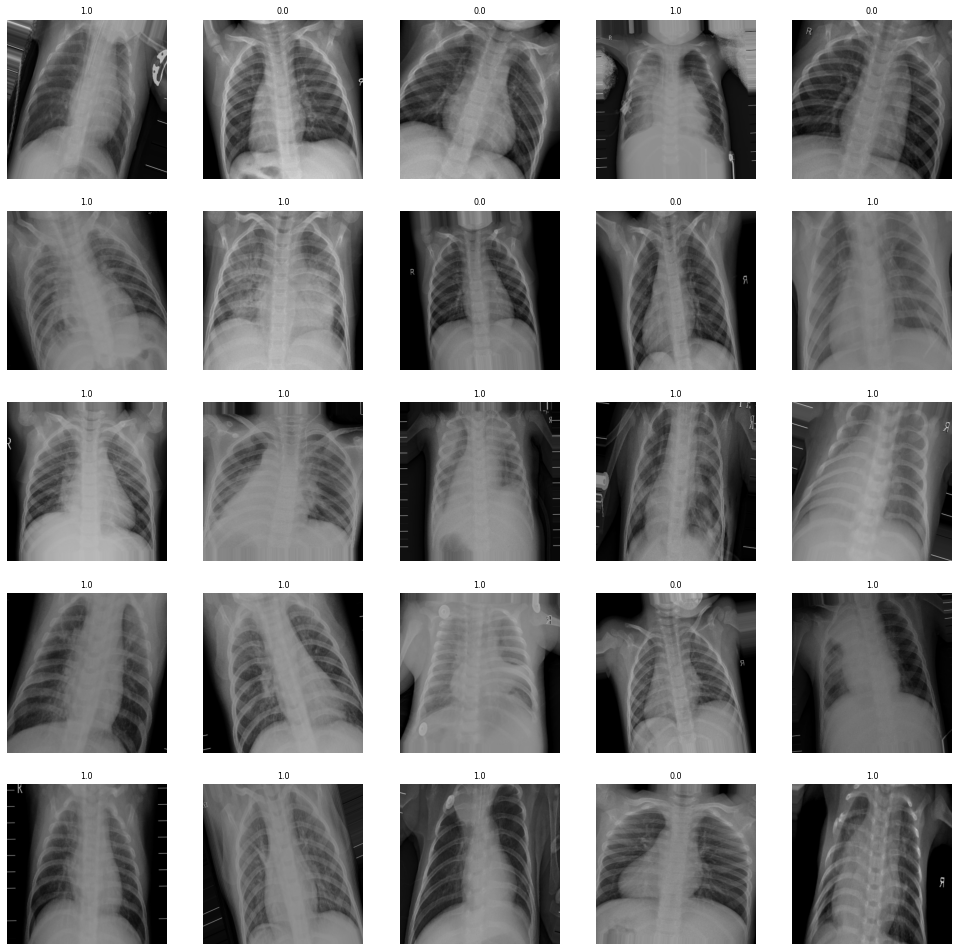

In [12]:
# viualize some images after the augmentation
x_batch, y_batch = next(train_generator)
W = 5
H = 5
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array
for i in np.arange(0, W * H): 

    # Select a random image
    image = x_batch[i]
    # read and display an image with the selected index    
    axes[i].imshow( image )
    axes[i].set_title(y_batch[i], fontsize = 8) # the label
    axes[i].axis('off')

In [13]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [14]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

94668760/94668760 [==============================] - 2s 0us/step


In [15]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
best_model = ModelCheckpoint('.mdl_wts.hdf5', save_best_only = True, monitor = 'val_accuracy')

In [17]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', 
                             verbose=1, 
                             monitor='val_accuracy',
                             save_best_only=True, 
                             mode='max')

In [18]:
history = model2.fit(train_generator ,epochs=30, 
                    validation_data=validation_generator,
                     steps_per_epoch=100,
                    callbacks=[checkpoint,early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9062
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to model-001-0.906250-1.000000.h5
100/100 [==============================] - 707s 7s/step - loss: 0.2255 - accuracy: 0.9062 - val_loss: 0.1214 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9547
Epoch 2: val_accuracy did not improve from 1.00000
100/100 [==============================] - 327s 3s/step - loss: 0.1323 - accuracy: 0.9547 - val_loss: 0.0953 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9488
Epoch 3: val_accuracy did not improve from 1.00000
100/100 [==============================] - 196s 2s/step - loss: 0.1231 - accuracy: 0.9488 - val_loss: 0.0825 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.103

In [19]:
# Evaluating the model on train and test
score = model2.evaluate(train_generator)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test_generator)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 172s 1s/step - loss: 0.0566 - accuracy: 0.9783
Train Loss:  0.056594450026750565
Train Accuracy:  0.9783359169960022
20/20 [==============================] - 148s 8s/step - loss: 0.2609 - accuracy: 0.9087

Test loss:  0.2609359920024872
Test Accuracy:  0.9086538553237915


Text(0.5, 1.0, 'Accuracy Evolution')

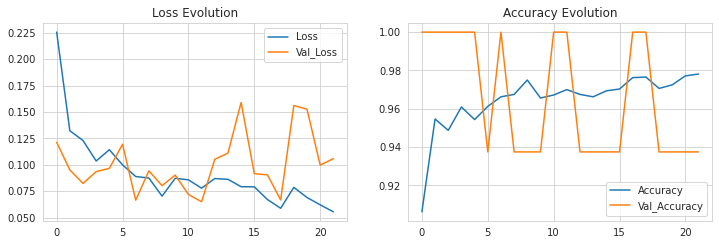

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [21]:
resnet_model.trainable = True

In [22]:
# how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [23]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [25]:
len(model2.trainable_variables)

86

In [26]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train_generator,epochs=total_epochs, 
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    callbacks=[checkpoint,early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9350
Epoch 1: val_accuracy did not improve from 1.00000
100/100 [==============================] - 118s 1s/step - loss: 0.2148 - accuracy: 0.9350 - val_loss: 8.3704 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9559
Epoch 2: val_accuracy did not improve from 1.00000
100/100 [==============================] - 116s 1s/step - loss: 0.1170 - accuracy: 0.9559 - val_loss: 5.2846 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9600
Epoch 3: val_accuracy did not improve from 1.00000
100/100 [==============================] - 107s 1s/step - loss: 0.1063 - accuracy: 0.9600 - val_loss: 0.2071 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9663
Epoch 4: val_accuracy did no

In [27]:
# Evaluating the model on train and test
score = model2.evaluate(train_generator)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test_generator)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 166s 1s/step - loss: 0.0232 - accuracy: 0.9912
Train Loss:  0.023215852677822113
Train Accuracy:  0.991180956363678
20/20 [==============================] - 7s 337ms/step - loss: 0.2245 - accuracy: 0.9167

Test loss:  0.2244694083929062
Test Accuracy:  0.9166666865348816


In [28]:
model2.save('tuned_resnet.h5')

In [29]:
final_model = tf.keras.models.load_model('tuned_resnet.h5')

In [30]:
y_pred = final_model.predict(test_generator)

20/20 [==============================] - 8s 341ms/step


In [31]:
final_model.evaluate(test_generator)

20/20 [==============================] - 8s 332ms/step - loss: 0.2245 - accuracy: 0.9167


[0.2244694083929062, 0.9166666865348816]